In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalizando e redimensionando
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [3]:
# Dimensões do espaço latente
latent_dim = 2

# Arquitetura do codificador
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Função para amostrar do espaço latente
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Arquitetura do decodificador
decoder_h = Dense(256, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Modelos finais
encoder = Model(inputs, [z_mean, z_log_var, z])
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

# Modelo VAE
vae = Model(inputs, decoder(encoder(inputs)[2]))


In [4]:
# Dimensões do espaço latente
latent_dim = 2

# Arquitetura do codificador
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Função para amostrar do espaço latente
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Arquitetura do decodificador
decoder_h = Dense(256, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Modelos finais
encoder = Model(inputs, [z_mean, z_log_var, z])
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

# Modelo VAE
vae = Model(inputs, decoder(encoder(inputs)[2]))


In [9]:
# Função de custo
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss(inputs, x_decoded_mean))


In [11]:
vae.compile(optimizer='rmsprop')
vae.fit(x_train, 
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.3901 - val_loss: 0.2675
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2652 - val_loss: 0.2638
Epoch 3/50
469/469 [==============================] - 5s 10ms/step - loss: 0.2637 - val_loss: 0.2633
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2633 - val_loss: 0.2631
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2632 - val_loss: 0.2629
Epoch 6/50
469/469 [==============================] - 6s 14ms/step - loss: 0.2631 - val_loss: 0.2628
Epoch 7/50
469/469 [==============================] - 5s 10ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2630 - val_loss: 0.2627
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2630 - val_loss: 

KeyboardInterrupt: 

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


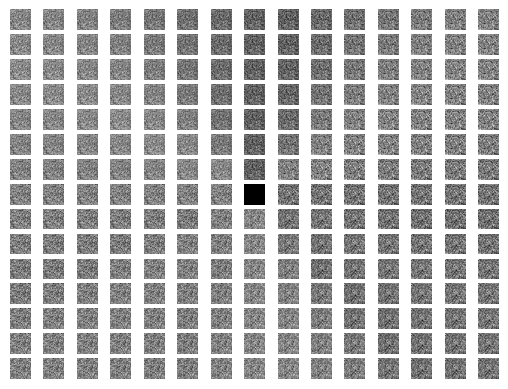

In [8]:
# Exemplo de visualização
n = 15  # número de dígitos para mostrar
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        plt.subplot(n, n, i * n + j + 1)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')

plt.show()
